# Image Colorization

## Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_io as tfio
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
%matplotlib inline

2023-10-25 16:27:55.851371: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 16:27:55.851439: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 16:27:55.851456: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 16:27:55.862238: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1331705936799366471
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4194304000
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11976527944761962889
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-10-25 16:27:57.644906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-25 16:27:57.645042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-25 16:27:57.645073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-25 16:27:57.645289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-25 16:27:57.645306: I tensorflow/core/co

## Importing Data

<font size = 4> As the dataset is very large and we will be training the deep learning model on GPU( VRAM = 4GB ), we will not be able to train the whole dataset in one go, so we will be using data generators provided by tensorflow library to import small batches of data at a time, keeping our algorithm memory efficient

In [5]:
def load_and_preprocess_images(input_image_path, output_image_path):
    input_image = tf.io.read_file(input_image_path)
    input_image = tf.image.decode_image(input_image, channels=1, expand_animations = False) 
    input_image = tf.image.resize(input_image, (160, 160))  
    input_image = input_image / 255.0  

    output_image = tf.io.read_file(output_image_path)
    output_image = tf.image.decode_image(output_image, channels=3, expand_animations = False)  
    output_image = tf.image.resize(output_image, (160, 160)) 
    output_image = output_image / 255.0  
    output_image = tfio.experimental.color.rgb_to_lab(output_image)
    output_image = output_image[:,:,1:3]

    return input_image, output_image

input_image_dir = os.path.join( os.getcwd(), "landscape Images", "gray")
output_image_dir = os.path.join( os.getcwd(), "landscape Images", "color")  

input_image_paths = [os.path.join( input_image_dir , filename) for filename in os.listdir(input_image_dir) if filename[-3:] == "jpg" ] 

output_image_paths = [os.path.join( output_image_dir , filename) for filename in os.listdir(output_image_dir) if filename[-3:] == "jpg" ]

input_dataset = tf.data.Dataset.from_tensor_slices(input_image_paths)
output_dataset = tf.data.Dataset.from_tensor_slices(output_image_paths)
dataset = tf.data.Dataset.zip(input_dataset, output_dataset)

dataset = dataset.map(load_and_preprocess_images)
dataset = dataset.shuffle(buffer_size=1000)  
test_dataset = dataset.take(700)
train_dataset = dataset.skip(700)
val_dataset = train_dataset.take(700)
train_dataset = train_dataset.skip(700)

train_dataset = train_dataset.batch(32) 
test_dataset = test_dataset.batch(32) 
val_dataset = val_dataset.batch(32) 


We will be using CIELAB color space, which requires three channels : one Lightness(or grayscale) channel and two color channels. We can use the grayscale image as the Lightness channel, requiring us to generate only two channnels for filling color into the image. 

In [6]:
def make_lab( L , a_b_array, shape = (160,160,3) ):
    img = np.empty( shape )
    img[:,:,0] = L[:,:,0] * 100
    img[:,:,1] = a_b_array[:,:,0]
    img[:,:,2] = a_b_array[:,:,1]
    return img.astype("float32")

def convert_to_rgb( L , a_b_array, shape = (160,160,3) ):
    lab = make_lab(L , a_b_array , shape)
    clr_img = cv2.cvtColor( lab, cv2.COLOR_LAB2RGB)
    return clr_img

In [7]:
def plot_image( color_image, gray_image,predicted_image = None ):
    plt.figure( figsize = ( 10 ,10 ) )
    plt.subplot( 1,3,1 )
    plt.title('Color Image', color = 'green', fontsize = 20)
    clr_img = convert_to_rgb( gray_image, color_image)
    plt.imshow( clr_img)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image', color = 'black', fontsize = 20)
    plt.imshow( gray_image, cmap = "gray")
    if(predicted_image is not None):
        plt.subplot(1,3,3)
        plt.title('Predicted Image', color = 'blue', fontsize = 20)
        clr_img = convert_to_rgb( gray_image, predicted_image)
        plt.imshow( clr_img )
            
    plt.show()

## Train-Test Split

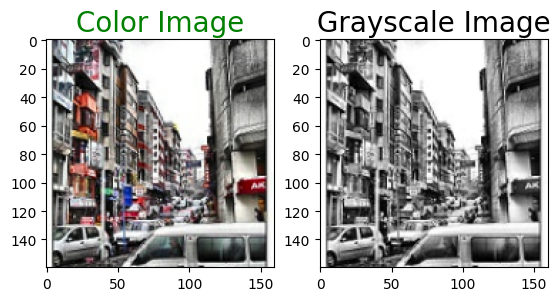

In [14]:
for batch in test_dataset.take(1):
    first_input_image_batch, first_output_image_batch = batch
    gray_image = first_input_image_batch[0]
    color_image = first_output_image_batch[0]
plot_image(color_image, gray_image)

## Autoencoder Architecture

<font size = 4> We will be using Autoencoder architecture, where the input image is downsampled by some encoder blocks reducing the dimensional complexity while simultaneously extracting the important features. The second step in this architecture is to upsample the image back to input dimension using decoder blocks. The final output we get from this process is an image of same dimensions as the input image, colorizing the image in the whole process. 

In [15]:
def encoder_downsample_block(inputs, num_filter, kernel_size):
    x = tf.keras.layers.Conv2D(num_filter, kernel_size, padding = "same")(inputs)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2)(x)
    return x

In [16]:
def decoder_upsample_block(inputs, Unet_upsample_image,num_filters , kernel_size): #skip_features): 

	x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs)
	x = tf.keras.layers.concatenate( [ x , Unet_upsample_image ] )
	x = tf.keras.layers.Conv2D(num_filters, kernel_size , padding = 'same')(x) 
	x = tf.keras.layers.Activation('relu')(x) 
	x = tf.keras.layers.BatchNormalization()(x)
	return x


In [17]:
def model():
    input_layer = tf.keras.layers.Input(shape = (160,160,1))
    e1 = encoder_downsample_block( input_layer, 32, (4,4) )
    e2 = encoder_downsample_block( e1, 64, (4,4) )
    e3 = encoder_downsample_block( e2, 128, (4,4) )
    e4 = encoder_downsample_block( e3, 256, (4,4) )
    
    b1 = tf.keras.layers.Conv2D( 512, (4,4), padding = "same" )(e4)
    b1 = tf.keras.layers.Activation("relu")(b1)
    b1 = tf.keras.layers.Conv2D( 512, (4,4), padding = "same" )(b1)
    b1 = tf.keras.layers.Activation("relu")(b1)
    b1 = tf.keras.layers.BatchNormalization()(b1)

    d1 = decoder_upsample_block ( b1, e3,  256, (4,4) )
    d2 = decoder_upsample_block( d1, e2, 128, (4,4) )
    d3 = decoder_upsample_block( d2, e1, 64, (4,4) )
    d4 = decoder_upsample_block( d3, input_layer, 32, (4,4) )
    output_layer = tf.keras.layers.Conv2D(2,(4,4),strides = 1, padding = 'same')(d4)
    return tf.keras.Model( inputs = input_layer, outputs = output_layer )

Callback to plot the progress of our neural network while training

In [18]:
class PlotProgress(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

        predicted_image = model.predict( np.reshape(gray_image, (1, 160, 160, 1) ))[0]
        plot_image(color_image, gray_image, predicted_image)

        

In [19]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 160, 160, 32)         544       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 160, 160, 32)         0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 160, 160, 32)         128       ['activation[0][0]']          
 Normalization)                                                                               

In [20]:
# count = 0
# for i in x_train:
#     if i.shape != (160,160,3):
#         plot_image( i,i)
#         print(i.shape)
#         count = count + 1
# for i in y_train:
#     if i.shape != (160,160,3):
#         plot_image(i,i)
#         print(i.shape)
#         count = count + 1
# print(count)

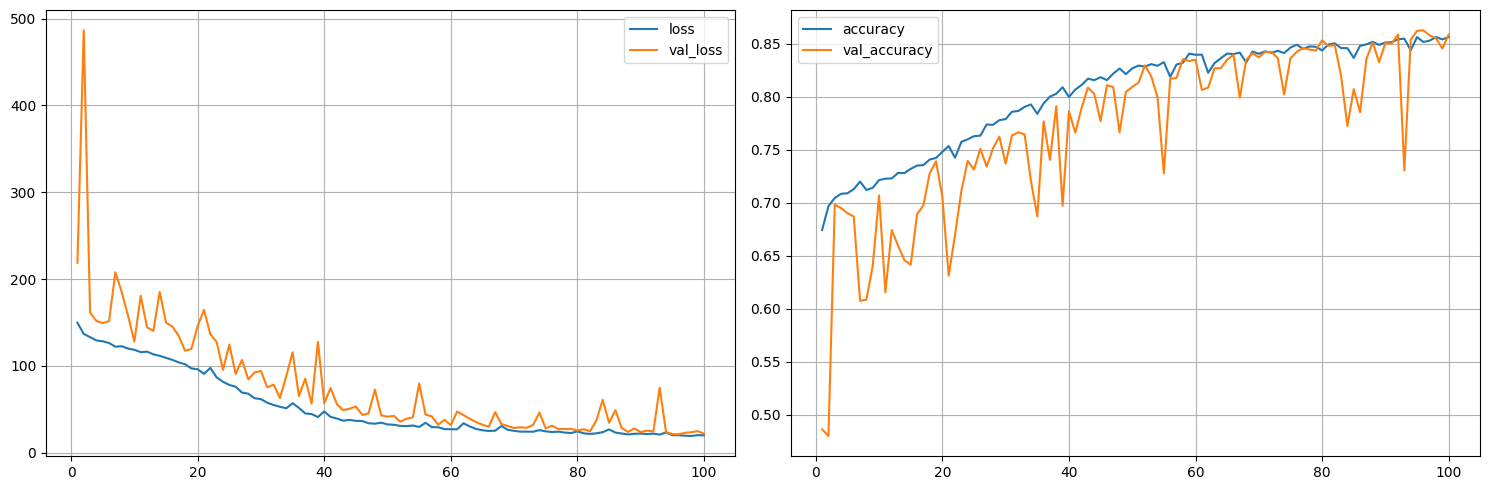

1/1 [==============================] - 0s 25ms/step


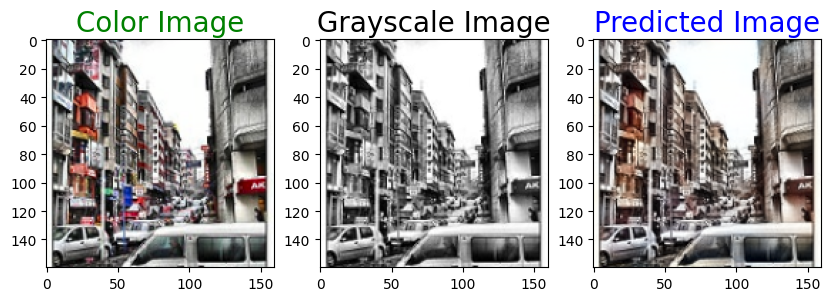

180/180 [==============================] - 42s 223ms/step - loss: 20.0213 - accuracy: 0.8564 - val_loss: 22.0700 - val_accuracy: 0.8589
INFO:tensorflow:Assets written to: ImageColorizationModel/assets


INFO:tensorflow:Assets written to: ImageColorizationModel/assets


In [21]:
checkpoint_filepath = './tmp/model/cp-{epoch:04d}.ckpt'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_freq="epoch",
    save_best_only=True)

callback_list = [PlotProgress(), model_checkpoint_callback]
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = tf.keras.losses.MSE ,metrics = ['accuracy'], )

model.fit(train_dataset, batch_size = 32, epochs = 100, callbacks = callback_list , validation_data= val_dataset)
model.save("ImageColorizationModel")


1/1 [==============================] - 0s 14ms/step


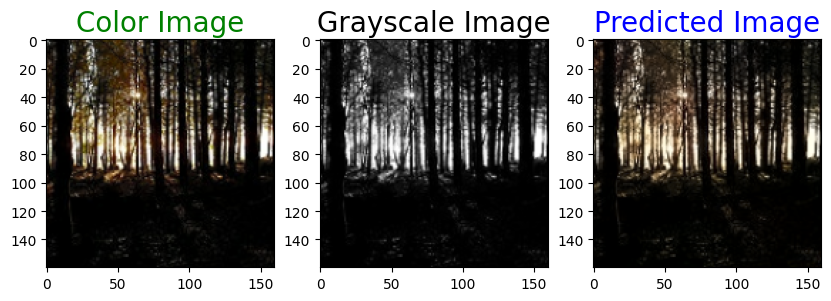

1/1 [==============================] - 0s 17ms/step


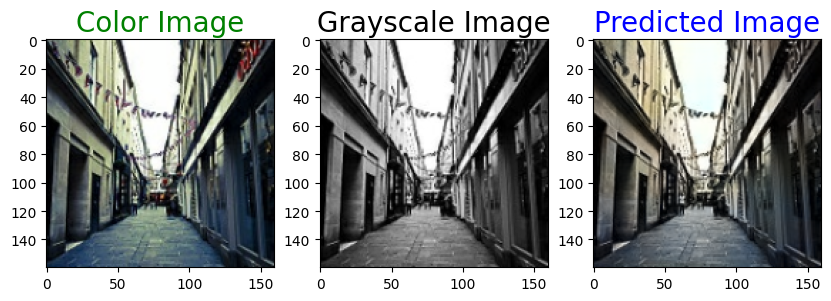

1/1 [==============================] - 0s 21ms/step


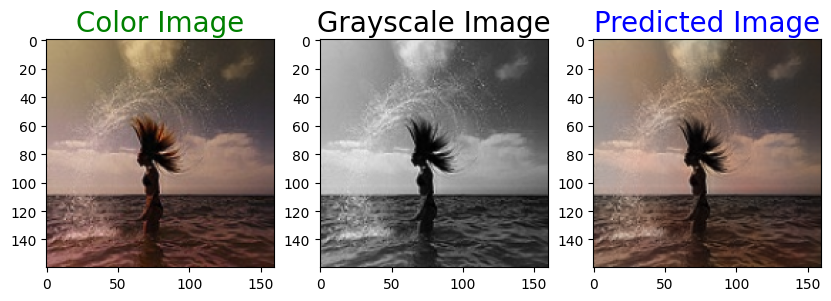

1/1 [==============================] - 0s 20ms/step


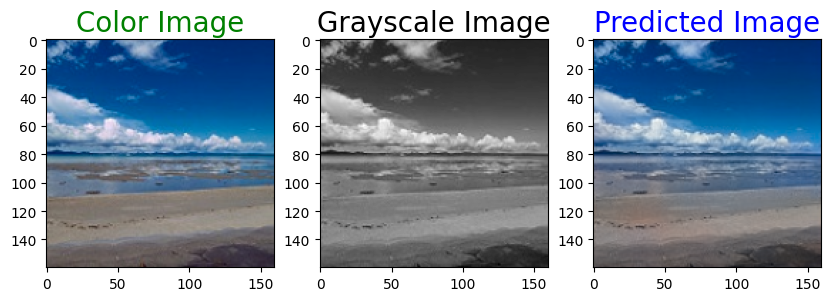

1/1 [==============================] - 0s 22ms/step


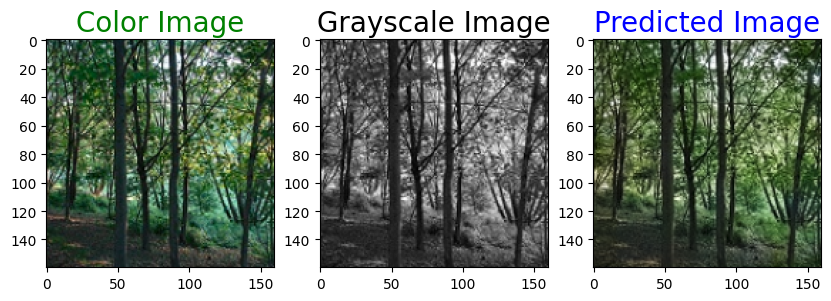

1/1 [==============================] - 0s 17ms/step


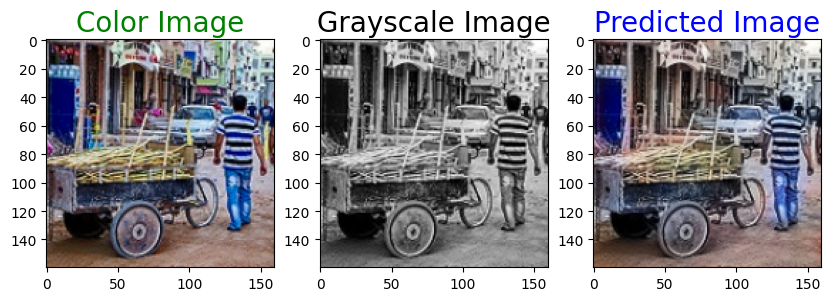

1/1 [==============================] - 0s 17ms/step


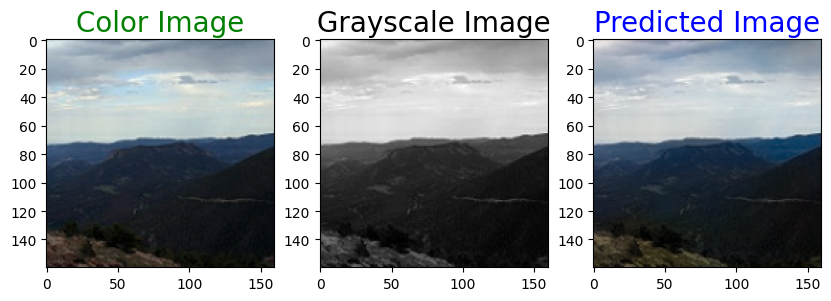

1/1 [==============================] - 0s 17ms/step


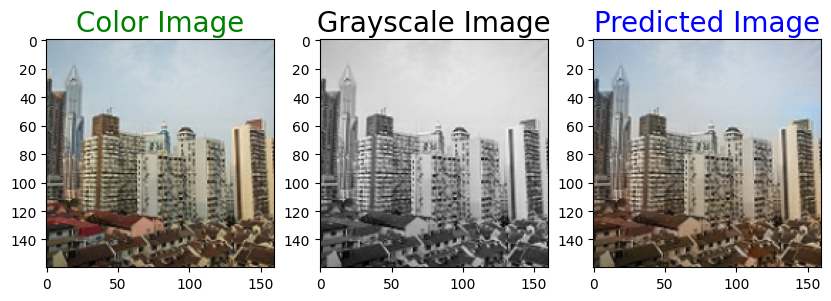

1/1 [==============================] - 0s 19ms/step


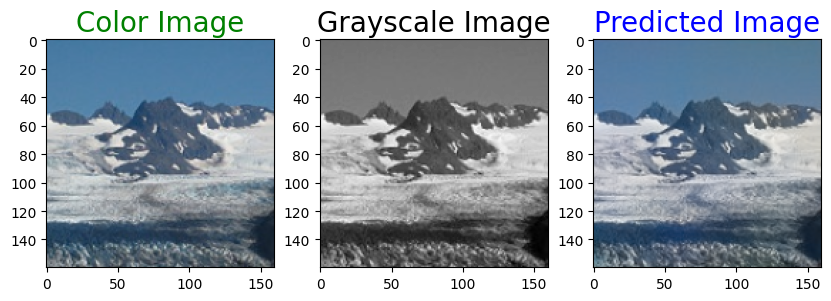

1/1 [==============================] - 0s 22ms/step


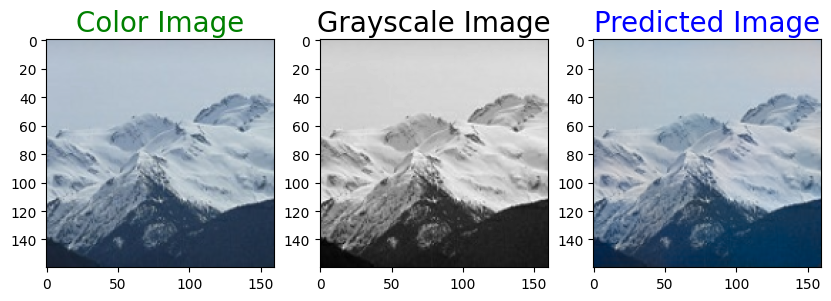

1/1 [==============================] - 0s 24ms/step


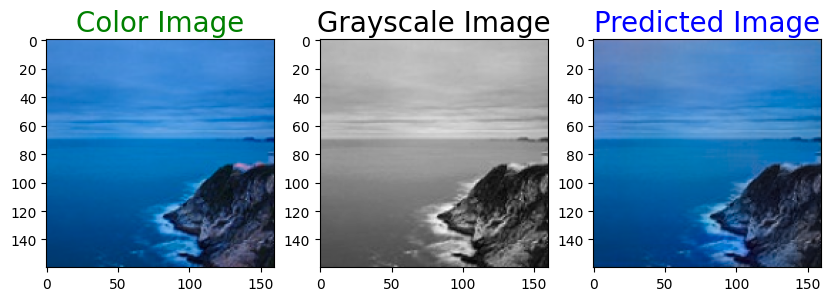

1/1 [==============================] - 0s 24ms/step


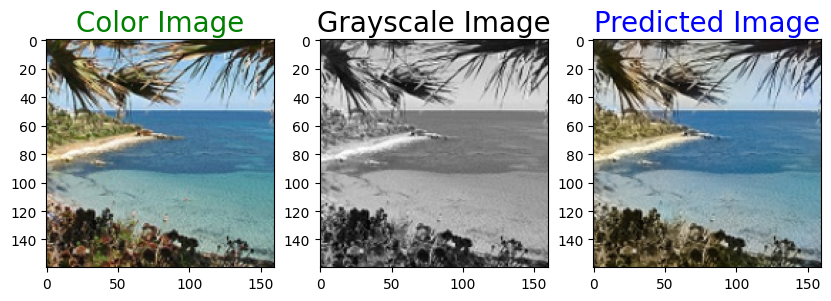

1/1 [==============================] - 0s 18ms/step


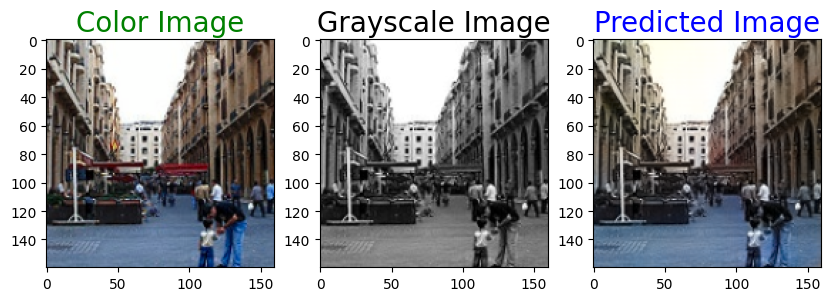

1/1 [==============================] - 0s 21ms/step


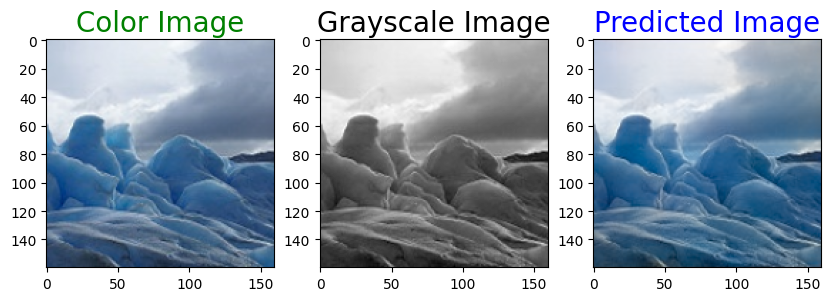

1/1 [==============================] - 0s 16ms/step


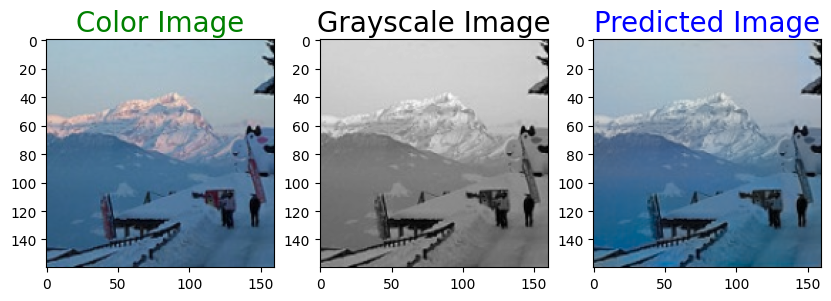

1/1 [==============================] - 0s 28ms/step


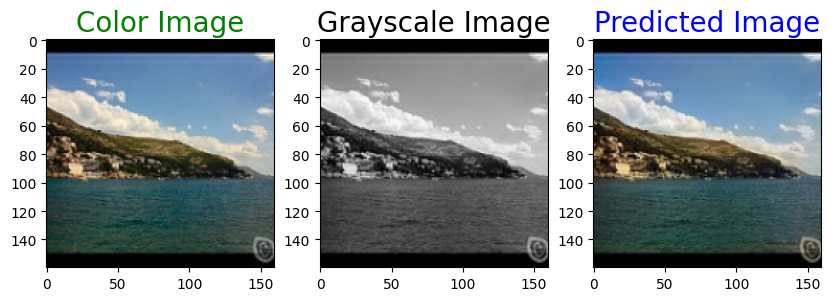

1/1 [==============================] - 0s 24ms/step


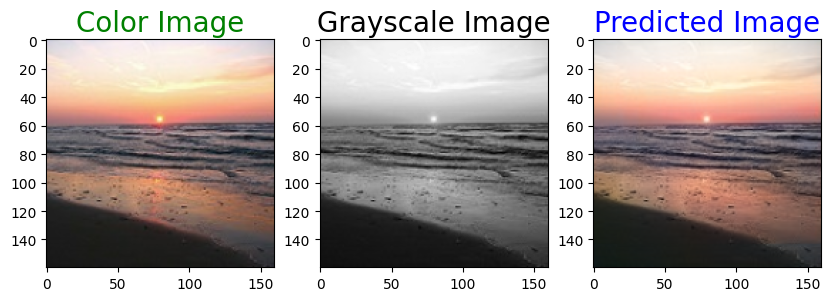

1/1 [==============================] - 0s 24ms/step


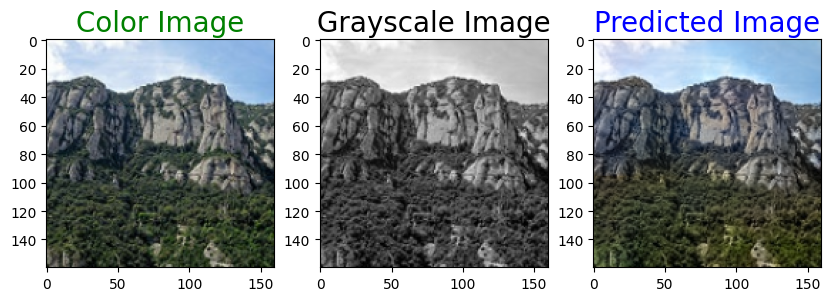

1/1 [==============================] - 0s 21ms/step


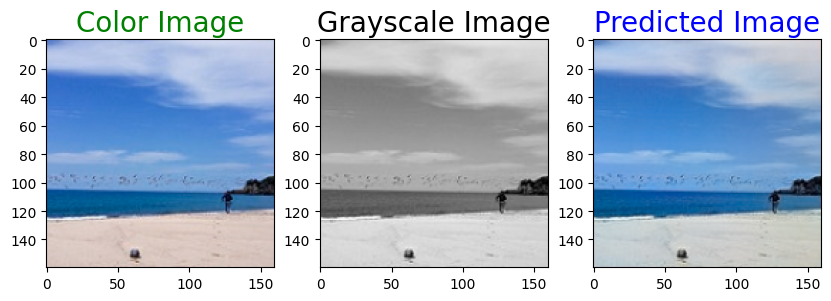

1/1 [==============================] - 0s 22ms/step


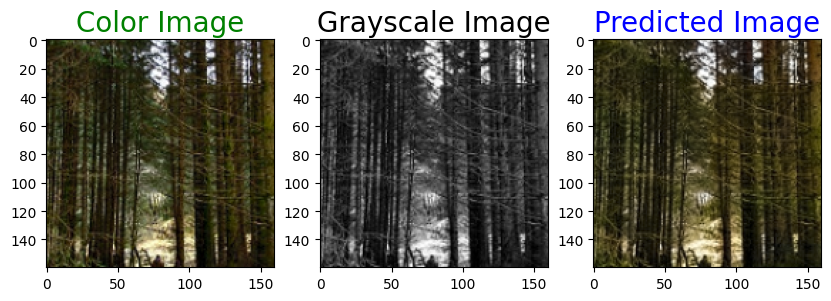

1/1 [==============================] - 0s 22ms/step


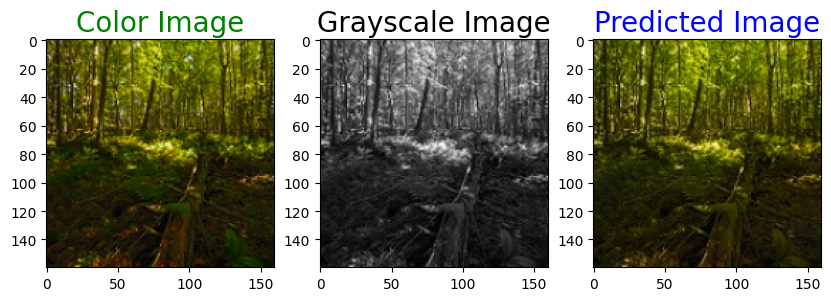

1/1 [==============================] - 0s 17ms/step


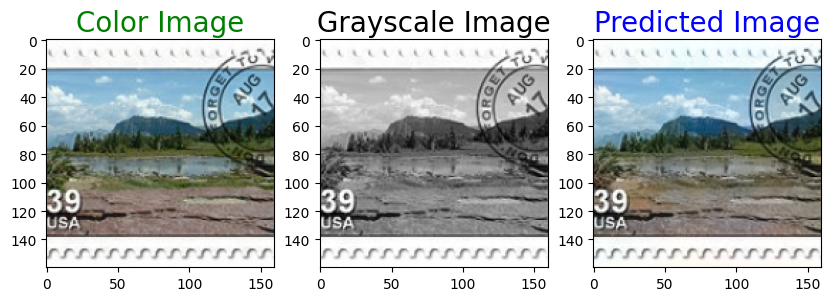

In [24]:
for batch in test_dataset.take(30):
    first_input_image_batch, first_output_image_batch = batch
    gray_image = first_input_image_batch[0]
    color_image = first_output_image_batch[0]
    predicted_image = model.predict( np.reshape(gray_image, (1, 160, 160, 1) ))[0]
    plot_image(color_image, gray_image,predicted_image)
#     plot_image(y_test[i], x_test[i], predicted_image)